In [21]:
###############################
# import packages
###############################
%config Completer.use_jedi = False
import os
import matplotlib.pyplot as plt
%matplotlib inline
#import sys
#print(sys.path)

In [22]:
###############################
# enable GPUs
###############################
from utils import enable_gpu

# default 0 to get the first gpu, if you have more than one you can make them into one list. Exemple "0,2" to indicate the gpu : 0 and gpu : 2.
gpu_list = None
if gpu_list is not None:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_list
    gpu_code = enable_gpu(list(range(len(gpu_list.split(',')))))
    if gpu_code < 1:
        print('[ERROR ENABLE GPU ]')
        os.environ['CUDA_VISIBLE_DEVICES'] = ""
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [23]:
###############################
# load model
###############################
from tensorflow.keras.models import load_model
#prepare model
metric_threshold = 0.5
Model_path = "./models/UnetMobileNetV3Small.h5"
model = load_model(Model_path)

In [24]:
###############################
# define path to images
###############################
from utils import is_path

#define path to images
subset = "test"
path_valid_file = is_path("data/image_distribution/{}.txt".format(subset))
path_valid_image_folder_FC = is_path("data/false_color/")
path_valid_image_folder_RGB = is_path("data/RGB/")
path_valid_gtmask_folder = is_path("data/masks/")


In [25]:
###############################
# Get all images paths
###############################
from utils import get_files_list

validation_path_image_list_FC = get_files_list(path_valid_file, path_valid_image_folder_FC, extension='.tif')
print(len(validation_path_image_list_FC))
print(validation_path_image_list_FC[-3:])

6
['data/false_color/Sentinel-2_L1C_from_2019-03-04_Traralgon_22.tif', 'data/false_color/Sentinel-2_L1C_from_2019-03-04_Traralgon_71.tif', 'data/false_color/Sentinel-2_L1C_from_2019-03-04_Traralgon_76.tif']


In [26]:
def transform_predicted_mask(pred_mask, threshhold=0.5):
    pred_mask[pred_mask >= threshhold] = 1.0
    pred_mask[pred_mask < threshhold] = 0.0
    return pred_mask.astype(np.uint8)


def predict(model, image, threshhold=0.5):
    """
    use the model to predict a mask from image as input
    """
    pred_mask = model.predict(image)
    return transform_predicted_mask(pred_mask, threshhold=threshhold)


def create_images_from_bands(a, channels_list=None):
    """
    This function can help you to extract some bands from the multispectral data
    :param a: array [D1,D2,D3] dimension
    :param channels_list: list of channel to extract from D3
    :return: array [D1,D2,|channels_list|]
    """
    if channels_list is None:
        channels_list = [3, 2, 1]
    c = np.zeros((a.shape[0], a.shape[1], len(channels_list)), dtype=a.dtype)
    for i, j in enumerate(channels_list):
        c[:, :, i] = a[:, :, j]

    return c


def intersection_over_union(actual, pred):
    intersection = np.logical_and(actual, pred).sum()
    union = np.logical_or(actual, pred).sum()
    return intersection / union




In [27]:

def get_confusion_matrix_intersection_mats(groundtruth, predicted):
    """
    Returns dict of 4 boolean numpy arrays with True at TP, FP, FN, TN
    """
    confusion_matrix_arrs = {}
    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    confusion_matrix_arrs['tp'] = np.logical_and(groundtruth, predicted)
    confusion_matrix_arrs['tn'] = np.logical_and(groundtruth_inverse, predicted_inverse)
    confusion_matrix_arrs['fp'] = np.logical_and(groundtruth_inverse, predicted)
    confusion_matrix_arrs['fn'] = np.logical_and(groundtruth, predicted_inverse)

    return confusion_matrix_arrs


def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, colors):
    """
    Returns overlay the 'image' with a color mask where TP, FP, FN, TN are
    each a color given by the 'colors' dictionary
    """
    masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
    color_mask = np.zeros_like(image)
    for label, mask in masks.items():
        color = colors[label]
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask != 0] = color
        color_mask += mask_rgb
    return color_mask





In [28]:
def display(display_list, title_list=None,save_path=None):
    fig=plt.figure(figsize=(40, 10))
    if title_list is None:
        title = ['Input Image', 'GT Mask', 'Predicted Mask']
    else:
        title = title_list
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i], c='BLACK')
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    if save_path is not None:
        fig.savefig(save_path+'.jpg',bbox_inches='tight', dpi=150)

def display_matrix(matrix,title_list,path_save="image"):
    columns = len(matrix[0])
    rows = len(matrix)
    fig=plt.figure(figsize=(5*columns,5*rows))


    for j in range(0,rows):
        for i in range(0,columns):
            ax=fig.add_subplot(rows,columns,(columns*j)+i+1)
            if j == 0:
                ax.set_title(title_list[i],c='black')
            ax.set_aspect('equal')
            plt.imshow(matrix[j][i])
            plt.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    fig.savefig(path_save+'.jpg',bbox_inches='tight', dpi=150)

In [29]:
import numpy as np
from utils import data_read, ndarray_info
from skimage.util import img_as_ubyte,img_as_float
from tqdm import tqdm

confusion_matrix_colors = {
    'tp': (0, 255, 0),  #green
    'fp': (0, 0, 255),  #BLUE
    'fn': (255, 0, 0),  #RED
    'tn': (0, 0, 0)  #black
}

matrix=[] # [[RGB,FC,GT,PR]]
for counter, image_path_fc in tqdm(enumerate(validation_path_image_list_FC)):
    ###############################
    # info about each step
    ###############################
    print("[INFO] Read file n° {} : {}".format(counter,image_path_fc))

    ###############################
    # create paths
    ###############################
    gtmask_path = image_path_fc.replace(path_valid_image_folder_FC, path_valid_gtmask_folder)
    image_path_RGB = image_path_fc.replace(path_valid_image_folder_FC, path_valid_image_folder_RGB)

    ###############################
    # read data
    ###############################
    image_fc = data_read(image_path_fc)
    image_RGB = (img_as_float(data_read(image_path_RGB))*2.0)
    image_RGB[image_RGB>1.0]=1.0
    image_RGB=img_as_ubyte(image_RGB)
    gtmask = data_read(gtmask_path)

    #validation_mask_PM = get_confusion_matrix_overlaid_mask(image_fc, gtmask, PM_mask, confusion_matrix_colors)
    #validation_mask_nano = get_confusion_matrix_overlaid_mask(image_fc,gtmask, nano_mask, confusion_matrix_colors)

    ###############################
    # predict from model
    ###############################
    # transform data
    image_fc = np.expand_dims(image_fc, axis=0)
    #predict data
    pred_mask = predict(model, image_fc, threshhold=metric_threshold)
    image_fc = np.squeeze(image_fc, axis=0)
    pred_mask = np.squeeze(pred_mask, axis=(0, -1))

    ###############################
    #  data info
    ###############################
    # ndarray_info(image_RGB)
    # ndarray_info(image_fc)
    # ndarray_info(gtmask, count_non_zero=True)

    ###############################
    # calculate scores
    ###############################
    prediction_score = intersection_over_union(gtmask, pred_mask)
    ###############################
    # print scores
    ###############################
    print('[INFO] : IoU score  :   {} '.format(prediction_score))

    ###############################
    # display images
    ###############################
    validation_mask_pred = get_confusion_matrix_overlaid_mask(image_fc, gtmask, pred_mask, confusion_matrix_colors)
    gtmask = get_confusion_matrix_overlaid_mask(image_fc, gtmask, gtmask, confusion_matrix_colors)
    #display([image_RGB, image_fc, gtmask, validation_mask_pred], title_list=['RGB', 'FC', 'GT Mask', 'mask predict'])
    # add images, Gt mask and pred mask to matrix for displaying
    matrix.append([image_RGB, image_fc, gtmask, validation_mask_pred])


0it [00:00, ?it/s]

[INFO] Read file n° 0 : data/false_color/Sentinel-2_L1C_from_2018-08-23_Mendocino_13.tif
1/1 [==============================] - 1s 1s/step


1it [00:01,  1.31s/it]

[INFO] : IoU score  :   0.9854689564068693 
[INFO] Read file n° 1 : data/false_color/Sentinel-2_L1C_from_2018-08-23_Mendocino_27.tif
1/1 [==============================] - 0s 56ms/step


2it [00:01,  1.65it/s]

[INFO] : IoU score  :   0.9903209373408048 
[INFO] Read file n° 2 : data/false_color/Sentinel-2_L1C_from_2018-11-16_Chico_5.tif
1/1 [==============================] - 0s 53ms/step


3it [00:01,  2.62it/s]

[INFO] : IoU score  :   0.9836065573770492 
[INFO] Read file n° 3 : data/false_color/Sentinel-2_L1C_from_2019-03-04_Traralgon_22.tif
1/1 [==============================] - 0s 40ms/step


4it [00:01,  3.68it/s]

[INFO] : IoU score  :   0.9854051333668847 
[INFO] Read file n° 4 : data/false_color/Sentinel-2_L1C_from_2019-03-04_Traralgon_71.tif
1/1 [==============================] - 0s 37ms/step


5it [00:01,  4.74it/s]

[INFO] : IoU score  :   0.9808350444900753 
[INFO] Read file n° 5 : data/false_color/Sentinel-2_L1C_from_2019-03-04_Traralgon_76.tif
1/1 [==============================] - 0s 37ms/step
[INFO] : IoU score  :   0.9616362096091008 


6it [00:01,  3.26it/s]


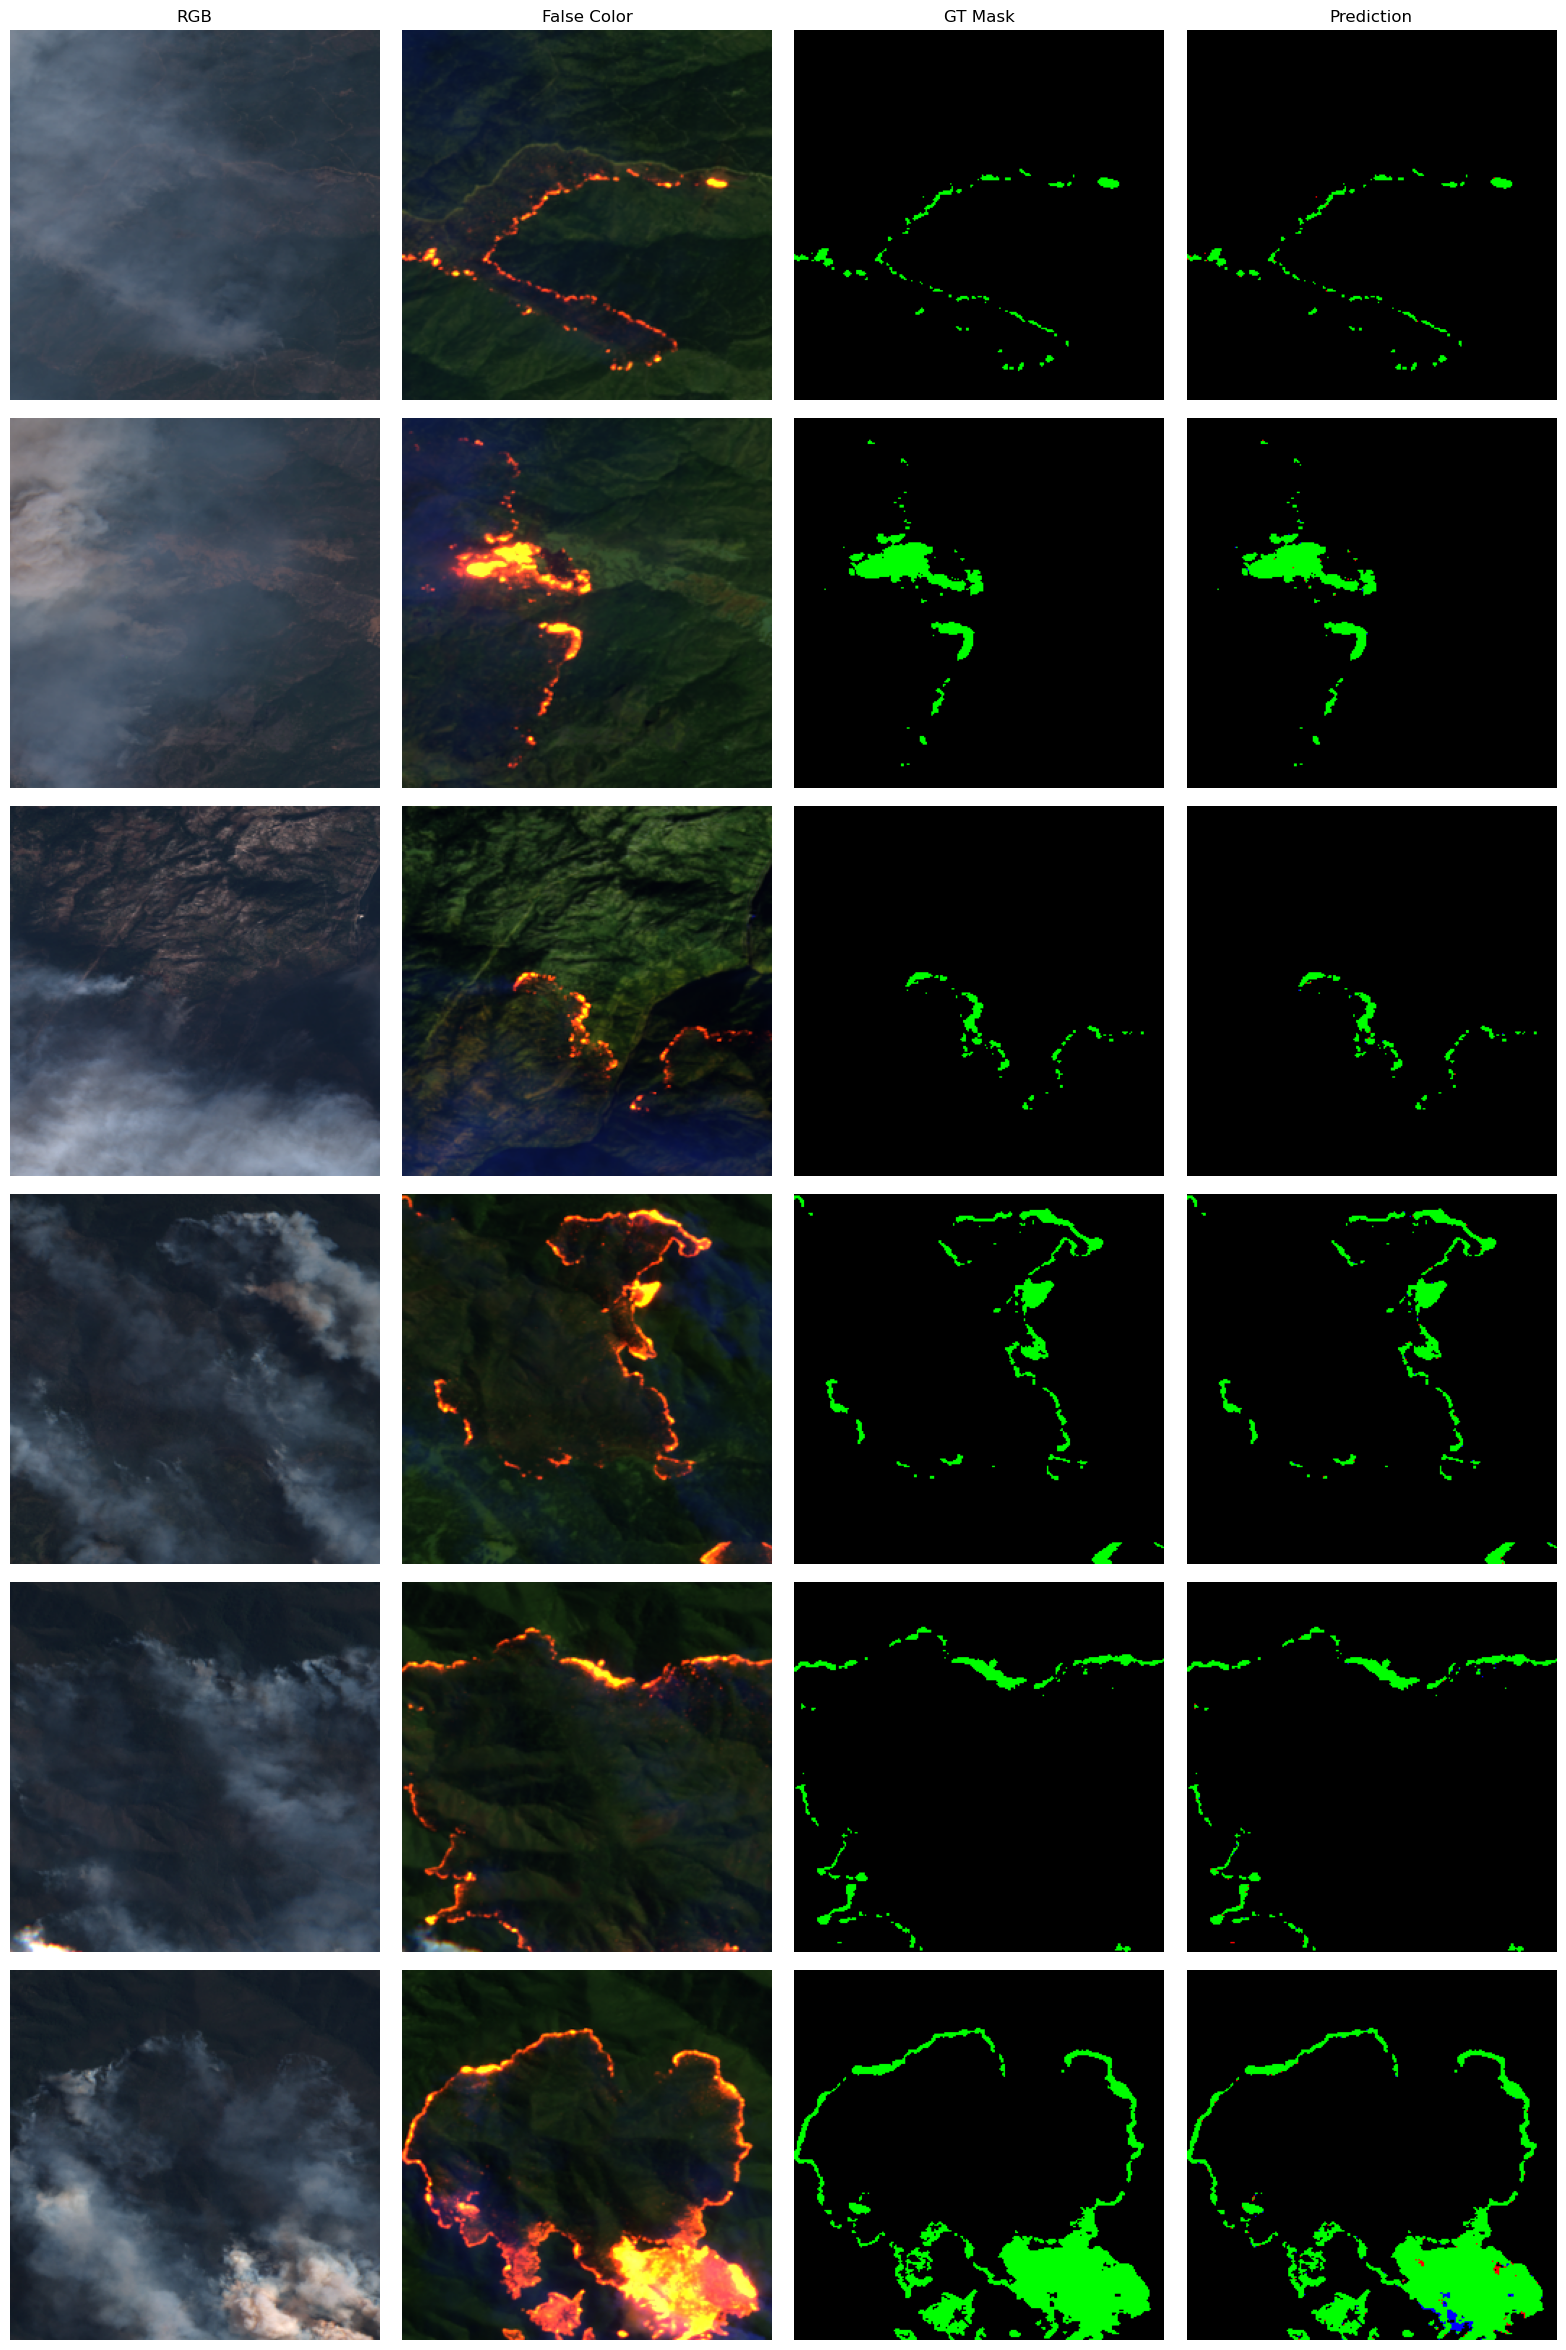

In [30]:
display_matrix(matrix ,title_list=['RGB','False Color', 'GT Mask','Prediction'],path_save='images/predictions')